In [5]:
import torch
import torchvision
import os
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import cv2
import copy

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [7]:
# split dataset
posA = "dataset/celeA"
posB = "dataset/flickr"
negA = "dataset/stylegan"
negB = "dataset/fake1000/"

In [8]:
traindata = [os.path.join(posA,filename)for filename in os.listdir(posA)][:800] + \
            [os.path.join(posB,filename)for filename in os.listdir(posB)][:800] + \
            [os.path.join(negA,filename)for filename in os.listdir(negA)][:800] + \
            [os.path.join(negB,filename)for filename in os.listdir(negB)][:800]
trainlabel = [1]*1600 + [0]*1600

validdata = [os.path.join(posA,filename)for filename in os.listdir(posA)][800:900] + \
            [os.path.join(posB,filename)for filename in os.listdir(posB)][800:900] + \
            [os.path.join(negA,filename)for filename in os.listdir(negA)][800:900] + \
            [os.path.join(negB,filename)for filename in os.listdir(negB)][800:900]
validlabel = [1]*200 + [0]*200

testdata  = [os.path.join(posA,filename)for filename in os.listdir(posA)][900:] + \
            [os.path.join(posB,filename)for filename in os.listdir(posB)][900:] + \
            [os.path.join(negA,filename)for filename in os.listdir(negA)][900:] + \
            [os.path.join(negB,filename)for filename in os.listdir(negB)][900:]
testlabel = [1]*200 + [0]*200

len(traindata),len(validdata),len(testdata),len(trainlabel),len(validlabel),len(testlabel)

(3200, 400, 400, 3200, 400, 400)

In [5]:
class DeepfakeData(Dataset):
    def __init__(self, pathList, labelList, transform=None):
        self.pathList = pathList
        self.labelList = labelList
        self.transform = transform

    def __len__(self):
        return len(self.pathList)
    
    def __getitem__(self,index):
        
        img = cv2.imread(self.pathList[index])        
        label = self.labelList[index]
        
        if self.transform:
            img = self.transform(img)
            
        return img, label


In [6]:
transform = transforms.Compose([transforms.ToTensor()])
traindataset = DeepfakeData(traindata, trainlabel, transform)
validdataset = DeepfakeData(validdata, validlabel, transform)
testdataset = DeepfakeData(testdata, testlabel, transform)

In [7]:
batchsize = 4
trainloader = DataLoader(traindataset, batch_size=batchsize, shuffle=True, num_workers=4)
validloader = DataLoader(validdataset)
testloader = DataLoader(testdataset)

### train

In [8]:
net = torchvision.models.resnet18(pretrained=True)
net.fc = torch.nn.Linear(in_features=512, out_features=2, bias=True)
net.cuda()
epoch_max = 50
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
acc_max = 0
for epoch in range(epoch_max):
    loss_epoch = 0
    loss_count = 0
    net.train()
    for i, (img,label) in enumerate(trainloader):
        img = img.cuda()
        label = torch.tensor(label,dtype=torch.int64).cuda()

        optimizer.zero_grad()
        output = net(img)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss
        loss_count += 1
        
        if i*batchsize%400 == 0:
            print("Epoch:{} Loss:{} iter:{}".format(epoch, loss_epoch/loss_count, i*batchsize))
            loss_epoch = 0
            loss_count = 0
            
    
            
    loss_epoch = 0
    loss_count = 0
    predict = []
    expect = []
    net.eval()
    for i, (img,label) in enumerate(validloader):
        img = img.cuda()
        label = torch.tensor(label,dtype=torch.int64).cuda()
        with torch.no_grad():
            output = net(img)
        loss = criterion(output, label)
        
        loss_epoch += loss
        loss_count += 1
        
        predict.append(np.argmax(output.cpu().numpy()))
        expect.append(label.cpu().numpy().item())
    acc = accuracy_score(expect, predict)
    pre = precision_score(expect, predict)
    rec = recall_score(expect, predict)
    
    if acc_max < acc:
        print("!")
        acc_max = acc
        best_model_wts = copy.deepcopy(net.state_dict())
        best_epoch = epoch
    
    print("EVALUATION\nEpoch:{} Loss:{} acc:{} precision:{} recall:{}".format(epoch, loss_epoch/loss_count, acc, pre, rec))
    print("##########################################################################")

/data/home/wws/environment/python3.5.2/local/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Epoch:0 Loss:0.6628390550613403 iter:0
Epoch:0 Loss:0.6648040413856506 iter:400
Epoch:0 Loss:0.4602664113044739 iter:800
Epoch:0 Loss:0.6546984910964966 iter:1200
Epoch:0 Loss:0.5180612206459045 iter:1600
Epoch:0 Loss:0.45153412222862244 iter:2000
Epoch:0 Loss:0.5575727224349976 iter:2400
Epoch:0 Loss:0.3966757357120514 iter:2800


/data/home/wws/environment/python3.5.2/local/lib/python3.5/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


!
EVALUATION
Epoch:0 Loss:0.14263977110385895 acc:0.9475 precision:0.9162790697674419 recall:0.985
##########################################################################
Epoch:1 Loss:0.8788368105888367 iter:0
Epoch:1 Loss:0.40137365460395813 iter:400
Epoch:1 Loss:0.24920138716697693 iter:800
Epoch:1 Loss:0.35153305530548096 iter:1200
Epoch:1 Loss:0.5678660273551941 iter:1600
Epoch:1 Loss:0.4107319116592407 iter:2000
Epoch:1 Loss:0.3710213005542755 iter:2400
Epoch:1 Loss:0.35956108570098877 iter:2800
EVALUATION
Epoch:1 Loss:0.3197574019432068 acc:0.8775 precision:0.8032128514056225 recall:1.0
##########################################################################
Epoch:2 Loss:0.006168961524963379 iter:0
Epoch:2 Loss:0.30072906613349915 iter:400
Epoch:2 Loss:0.2528364956378937 iter:800
Epoch:2 Loss:0.27530235052108765 iter:1200
Epoch:2 Loss:0.3774586021900177 iter:1600
Epoch:2 Loss:0.39849504828453064 iter:2000
Epoch:2 Loss:0.3335346281528473 iter:2400
Epoch:2 Loss:0.2396426945924

Epoch:20 Loss:0.0010422321502119303 iter:2800
EVALUATION
Epoch:20 Loss:0.027658609673380852 acc:0.99 precision:0.99 recall:0.99
##########################################################################
Epoch:21 Loss:7.539987564086914e-05 iter:0
Epoch:21 Loss:0.0010869763791561127 iter:400
Epoch:21 Loss:0.0011552477953955531 iter:800
Epoch:21 Loss:0.0005938780377618968 iter:1200
Epoch:21 Loss:0.00047426819219253957 iter:1600
Epoch:21 Loss:0.0007538849022239447 iter:2000
Epoch:21 Loss:0.0009523570188321173 iter:2400
Epoch:21 Loss:0.00046608445700258017 iter:2800
EVALUATION
Epoch:21 Loss:0.027241630479693413 acc:0.99 precision:0.99 recall:0.99
##########################################################################
Epoch:22 Loss:0.00015974044799804688 iter:0
Epoch:22 Loss:0.00040922878542914987 iter:400
Epoch:22 Loss:0.0005431210738606751 iter:800
Epoch:22 Loss:0.0006604452501051128 iter:1200
Epoch:22 Loss:0.0004376108990982175 iter:1600
Epoch:22 Loss:0.00034505606163293123 iter:2000
E

Epoch:36 Loss:0.00019037723541259766 iter:0
Epoch:36 Loss:0.00020241558377165347 iter:400
Epoch:36 Loss:0.00036672622081823647 iter:800
Epoch:36 Loss:0.00020189880160614848 iter:1200
Epoch:36 Loss:0.00016541540389880538 iter:1600
Epoch:36 Loss:0.0002806037664413452 iter:2000
Epoch:36 Loss:0.0001918578054755926 iter:2400
Epoch:36 Loss:0.0002549257769715041 iter:2800
EVALUATION
Epoch:36 Loss:0.029204262420535088 acc:0.99 precision:0.99 recall:0.99
##########################################################################
Epoch:37 Loss:8.821487426757812e-06 iter:0
Epoch:37 Loss:0.00011125713353976607 iter:400
Epoch:37 Loss:0.00018782347615342587 iter:800
Epoch:37 Loss:0.00017061173275578767 iter:1200
Epoch:37 Loss:0.00012114673882024363 iter:1600
Epoch:37 Loss:0.00013510018470697105 iter:2000
Epoch:37 Loss:0.000176298912265338 iter:2400
Epoch:37 Loss:0.00014257400471251458 iter:2800
EVALUATION
Epoch:37 Loss:0.02924203872680664 acc:0.99 precision:0.99 recall:0.99
##########################

In [10]:
torch.save(best_model_wts,"Epoch{}_validAcc{}".format(best_epoch,acc_max))

In [12]:
net.load_state_dict(best_model_wts)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [19]:
epoch_max = 50
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

In [ ]:
acc_max = 0
for epoch in range(epoch_max):
    loss_epoch = 0
    loss_count = 0
    net.train()
    for i, (img,label) in enumerate(trainloader):
        img = img.cuda()
        label = torch.tensor(label,dtype=torch.int64).cuda()

        optimizer.zero_grad()
        output = net(img)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss
        loss_count += 1
        
        if i*batchsize%400 == 0:
            print("Epoch:{} Loss:{} iter:{}".format(epoch, loss_epoch/loss_count, i*batchsize))
            loss_epoch = 0
            loss_count = 0
            
    
            
    loss_epoch = 0
    loss_count = 0
    predict = []
    expect = []
    net.eval()
    for i, (img,label) in enumerate(validloader):
        img = img.cuda()
        label = torch.tensor(label,dtype=torch.int64).cuda()
        with torch.no_grad():
            output = net(img)
        loss = criterion(output, label)
        
        loss_epoch += loss
        loss_count += 1
        
        predict.append(np.argmax(output.cpu().numpy()))
        expect.append(label.cpu().numpy().item())
    acc = accuracy_score(expect, predict)
    pre = precision_score(expect, predict)
    rec = recall_score(expect, predict)
    
    if acc_max < acc:
        print("!")
        acc_max = acc
        best_model_wts = copy.deepcopy(net.state_dict())
        best_epoch = epoch
    
    print("EVALUATION\nEpoch:{} Loss:{} acc:{} precision:{} recall:{}".format(epoch, loss_epoch/loss_count, acc, pre, rec))
    print("##########################################################################")

/data/home/wws/environment/python3.5.2/local/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Epoch:0 Loss:8.511543273925781e-05 iter:0
Epoch:0 Loss:0.0005333950975909829 iter:400
Epoch:0 Loss:0.0001902544463519007 iter:800
Epoch:0 Loss:0.00011647939390968531 iter:1200
Epoch:0 Loss:0.00010525047400733456 iter:1600
Epoch:0 Loss:8.417963545070961e-05 iter:2000
Epoch:0 Loss:0.00021682350779883564 iter:2400
Epoch:0 Loss:0.00011860727681778371 iter:2800


/data/home/wws/environment/python3.5.2/local/lib/python3.5/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


!
EVALUATION
Epoch:0 Loss:0.027904722839593887 acc:0.9925 precision:0.9900497512437811 recall:0.995
##########################################################################
Epoch:1 Loss:6.74128532409668e-05 iter:0
Epoch:1 Loss:0.0002162331365980208 iter:400
Epoch:1 Loss:0.0001123237598221749 iter:800
Epoch:1 Loss:0.00020048349688295275 iter:1200
Epoch:1 Loss:0.00028244033455848694 iter:1600
Epoch:1 Loss:0.00025483936769887805 iter:2000
Epoch:1 Loss:0.00029715581331402063 iter:2400
Epoch:1 Loss:0.00010356485290685669 iter:2800
EVALUATION
Epoch:1 Loss:0.026607122272253036 acc:0.9925 precision:0.9900497512437811 recall:0.995
##########################################################################
Epoch:2 Loss:1.430511474609375e-05 iter:0
Epoch:2 Loss:0.0005641106981784105 iter:400
Epoch:2 Loss:0.00028030454996041954 iter:800
Epoch:2 Loss:0.00013691841741092503 iter:1200
Epoch:2 Loss:0.0001538362994324416 iter:1600
Epoch:2 Loss:0.00043996155727654696 iter:2000
Epoch:2 Loss:0.0001152378

Epoch:20 Loss:0.00017107278108596802 iter:2400
Epoch:20 Loss:0.0001015824091155082 iter:2800
EVALUATION
Epoch:20 Loss:0.028469862416386604 acc:0.99 precision:0.99 recall:0.99
##########################################################################
Epoch:21 Loss:1.0728836059570312e-06 iter:0
Epoch:21 Loss:0.0001577934599481523 iter:400
Epoch:21 Loss:0.00019431069085840136 iter:800
Epoch:21 Loss:0.00022876917500980198 iter:1200
Epoch:21 Loss:0.00013498961925506592 iter:1600
Epoch:21 Loss:0.00017431765445508063 iter:2000
Epoch:21 Loss:0.00011704474309226498 iter:2400
Epoch:21 Loss:7.157147047109902e-05 iter:2800
EVALUATION
Epoch:21 Loss:0.03165704384446144 acc:0.9875 precision:0.9899497487437185 recall:0.985
##########################################################################
Epoch:22 Loss:2.6226043701171875e-06 iter:0
Epoch:22 Loss:0.0001668137265369296 iter:400
Epoch:22 Loss:8.124887972371653e-05 iter:800
Epoch:22 Loss:0.0002969172492157668 iter:1200
Epoch:22 Loss:0.000167058708

In [ ]:
torch.save(best_model_wts,"Finetuning_Epoch{}_validAcc{}".format(best_epoch,acc_max))

### Visualization

In [8]:
import resnet_cam
import cam
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
net = resnet_cam.resnet18(pretrained=False)
net.fc = torch.nn.Linear(in_features=512, out_features=2, bias=True)

In [10]:
net.load_state_dict(torch.load("Finetuning_Epoch3_validAcc0.995"))
net.cuda()
_ = net.eval()

In [11]:
cam_drawer = cam.Drawer(net)

(2, 512, 1, 1)


In [135]:
predict = []
expect = []
for i in range(len(testdata)):
    imgPath = testdata[i]
    imgLabel = testlabel[i]
    pre_cls, raw_img, heatmap, _ = cam_drawer.get_heat_map(testdata[i],camtype=0)
    expect.append(imgLabel)
    predict.append(pre_cls)

In [136]:
acc = accuracy_score(expect, predict)
pre = precision_score(expect, predict)
rec = recall_score(expect, predict)
print("EVALUATION acc:{} precision:{} recall:{}".format(acc, pre, rec))

EVALUATION acc:1.0 precision:1.0 recall:1.0


两张合成图像被判定为真实图像


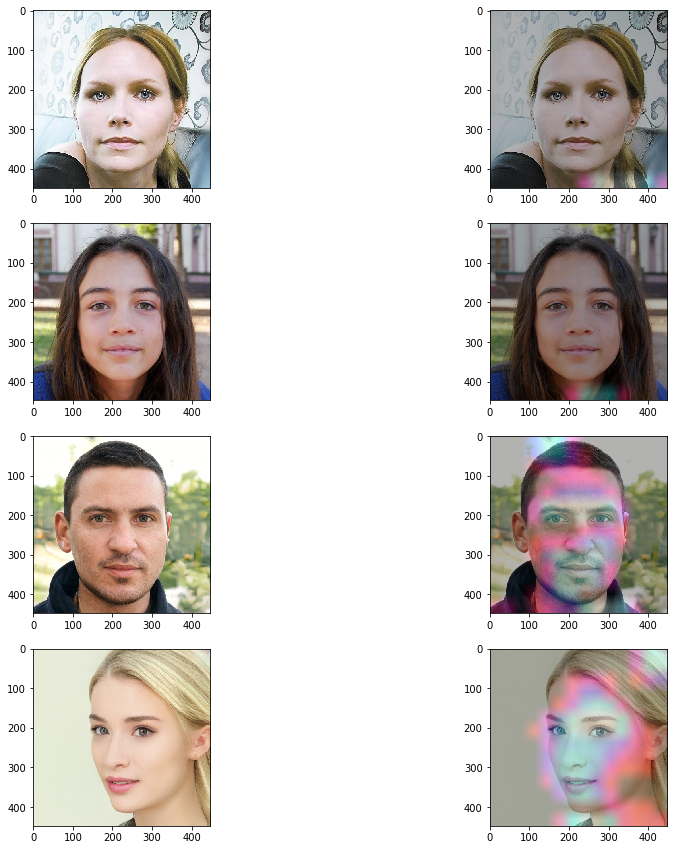

In [158]:
plt.figure(figsize=(15,15))

plt.subplot(421)
plt.imshow(cam_drawer.get_heat_map(testdata[1],camtype=0)[1])
plt.subplot(422)
plt.imshow(cam_drawer.get_heat_map(testdata[1],camtype=0)[2])

plt.subplot(423)
plt.imshow(cam_drawer.get_heat_map(testdata[101],camtype=0)[1])
plt.subplot(424)
plt.imshow(cam_drawer.get_heat_map(testdata[101],camtype=0)[2])

plt.subplot(425)
plt.imshow(cam_drawer.get_heat_map(testdata[201],camtype=0)[1])
plt.subplot(426)
plt.imshow(cam_drawer.get_heat_map(testdata[201],camtype=0)[2])

plt.subplot(427)
plt.imshow(cam_drawer.get_heat_map(testdata[301],camtype=0)[1])
plt.subplot(428)
plt.imshow(cam_drawer.get_heat_map(testdata[301],camtype=0)[2])

plt.show()

In [12]:
predict = []
expect = []
errorImg = []
errorCAM = []
errorGT = []
for i in range(len(validdata)):
    imgPath = validdata[i]
    imgLabel = validlabel[i]
    pre_cls, raw_img, heatmap, _ = cam_drawer.get_heat_map(validdata[i],camtype=0)
    expect.append(imgLabel)
    predict.append(pre_cls)
    
    if imgLabel!=pre_cls:
        errorImg.append(raw_img)
        errorCAM.append(heatmap)
        errorGT.append(imgLabel)
        print(i)

204
246


In [150]:
acc = accuracy_score(expect, predict)
pre = precision_score(expect, predict)
rec = recall_score(expect, predict)
print("EVALUATION acc:{} precision:{} recall:{}".format(acc, pre, rec))

EVALUATION acc:0.995 precision:0.9900990099009901 recall:1.0


两张合成图像被判定为真实图像


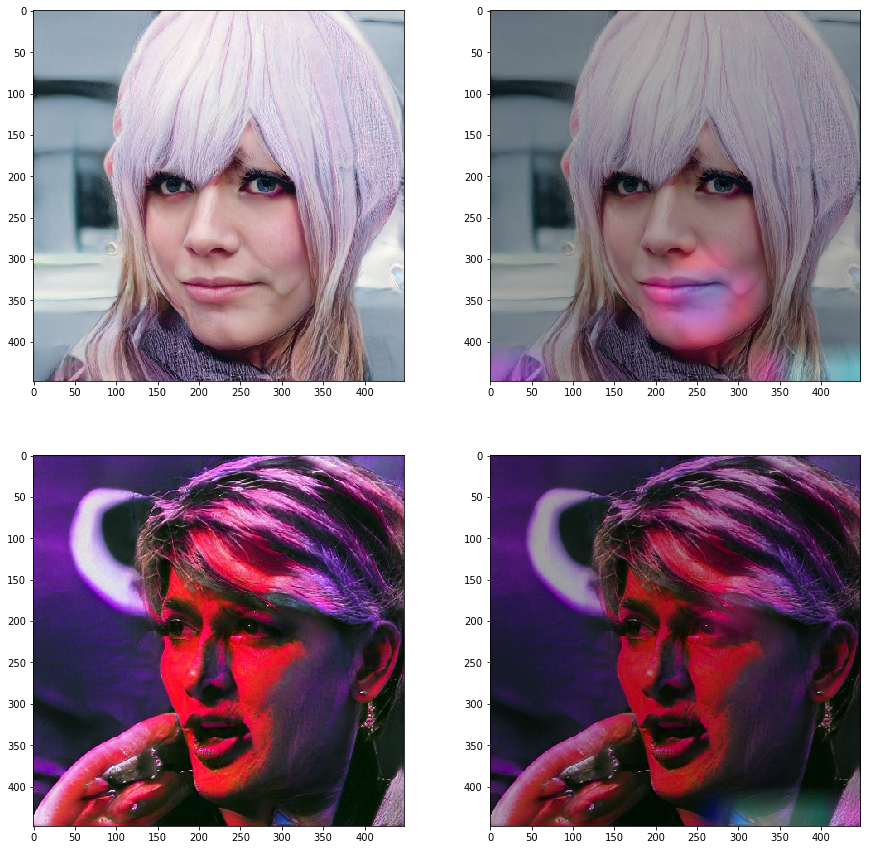

In [157]:
plt.figure(figsize=(15,15))
print("两张合成图像被判定为真实图像")

#print(errorGT[0])
plt.subplot(221)
plt.imshow(errorImg[0])
plt.subplot(222)
plt.imshow(errorCAM[0])

#print(errorGT[1])
plt.subplot(223)
plt.imshow(errorImg[1])
plt.subplot(224)
plt.imshow(errorCAM[1])

plt.show()